In [1]:
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from scipy.integrate import odeint
import scipy.integrate

In [2]:
# Show uninterpolated image with gray colormap
def grayim(input_image,ext=None):
    if ext == None:
        ext = [0,input_image.shape[0],0,input_image.shape[1]]
    imshow(input_image,
           interpolation='none',
           origin='lower',
           cmap='gray',
           extent=ext)

In [3]:
# Show uninterpolated image with gray colormap
def colorim(input_image,ext=None):
    if ext == None:
        ext = [0,input_image.shape[0],0,input_image.shape[1]]
    imshow(input_image,
           interpolation='none',
           origin='lower',
           extent=ext)

In [4]:
# Transform 1d array to the interval [0,1]
def normalize(x):
    x0 = x.min()
    x1 = x.max()
    T = (x-x0)/(x1-x0)
    return T

In [5]:
# Given a point, return the cell which it belongs to.
# Assume P is specified from bottom left,
# whereas cell is needed from top right
def grid_cell(P):
    P = P[...,::-1]
    return floor(P).astype(int)

In [6]:
# Return path length of parameterized path in 2d
# Input: nx2 array
# Output: scalar
def path_length(X):
    x = X[:,0]
    y = X[:,1]
    return sqrt(diff(x)**2+diff(y)**2)

In [7]:
path = array([
    [0,1],
    [1,1],
    [1,5],
    [2,5],
    [2,6],
    [1,7]])

(0.0, 2.0)

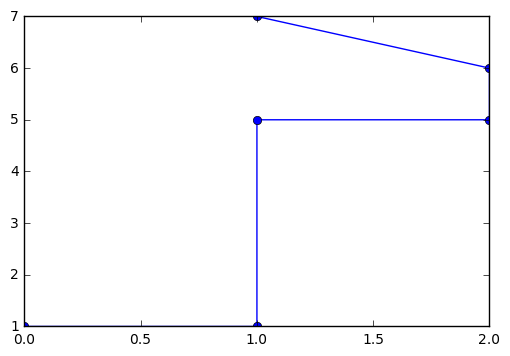

In [8]:
plot(path[:,0],path[:,1],'-ob')
xlim()
#gca().set_aspect('equal')

In [9]:
path_length(path).sum()-sqrt(2) # Looks good!

7.0000000000000009

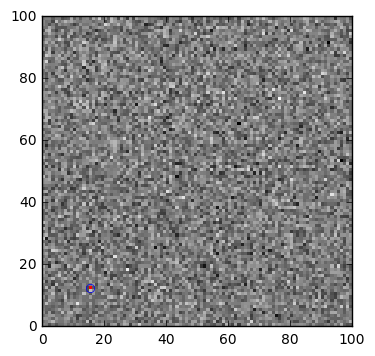

In [10]:
grid_size=[100,100]
mean=0,
std=1
# Generate white noise
noise = normalize(random.normal(mean,std,grid_size))
# Create 3d array of noise for RGB
noise = dstack([noise]*3)

grayim(noise)

# Plot point in grid cell
P = array([15.3,12.5])
plot(*P,'o',mec='b',mfc='None')
xlim(0,grid_size[0])
ylim(0,grid_size[1])

# Create grid like noise with alpha chanel highlighting Pf
zero_grid = zeros_like(noise[:,:,0])
red_grid = ones_like(noise)*[1,0,0]
alpha_grid = zero_grid

# Determine which cell from noise should be highlighted
Pf = grid_cell(P)

alpha_grid[Pf[0],Pf[1]] = 1
highlight_grid = dstack([red_grid,alpha_grid])

# Plot highlight
colorim(highlight_grid)


In [11]:
# Vector field
def F(xy,t=0):
    x,y = xy
    return array([sin(x*y),cos(x+y)])

In [12]:
def F_r(t,xy): return F(xy,t)

In [13]:
# Mesh
# Plot range
plot_range = [-5,5]
# Mesh spacing
dx = 1e-1
X,Y = mgrid[plot_range[0]:plot_range[1]:dx,plot_range[0]:plot_range[1]:dx]

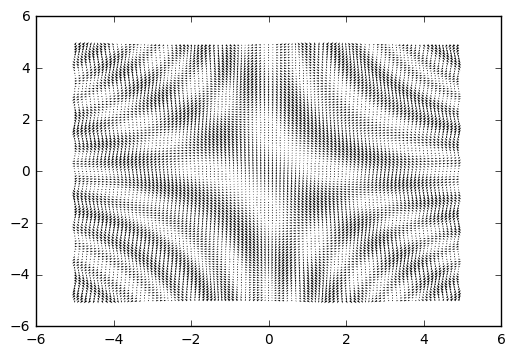

In [14]:
quiver(X,Y,*F([X,Y]))

In [15]:
init = [1,-1.9]
t = linspace(0,100,1001)
tp = linspace(0,-100,10001)
opts = {'rtol':1e-8,'atol':1e-8,'hmax':1e-3}
sol = odeint(F,init,t)
solp = odeint(F,init,tp)
sol_all = vstack([solp,sol])

In [16]:
ode15s = scipy.integrate.ode(F_r)
ode15s.set_integrator('vode', method='bdf', order=5, nsteps=3000)
ode15s.set_initial_value(init, t[0])

sol15s = array(init).reshape([1,2])
dt = 1e-2
while ode15s.successful() and ode15s.t < t[-1]:
    sol15s = vstack([sol15s,ode15s.integrate(ode15s.t+dt)])
    # Break if step size is too small
    #step_size = path_length(sol15s[-2:,:])
    #print("PL @ {}: {}".format(ode15s.t,step_size))
    #if step_size < 1e-5:
    #    break

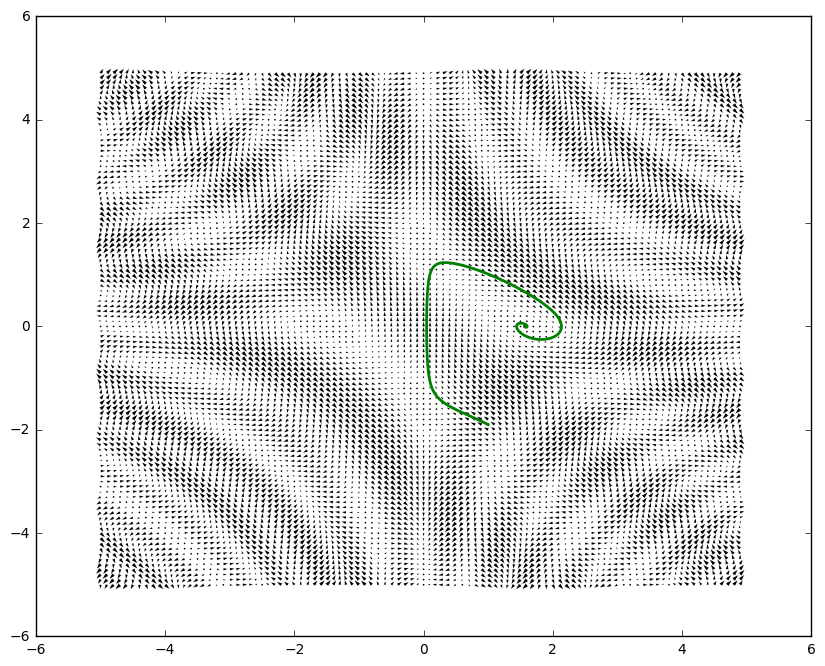

In [17]:
a=0
fig = figure(figsize=[10,8])
quiver(X,Y,*F([X,Y]))
plot(sol15s[a:,0],sol15s[a:,1],'g-',lw=2)

In [18]:
def stiff_int(F,t,init):
    def G(t,xy): return F(xy,t)
    def G_r(t,xy): return -F(xy,t)
    
    sol15s = array(init).reshape([1,2])
    dt = 1e-2
    
    # Timestep number
    k = 0
    
    # Integrate forwards in time
    if t > 0:
        ode15s = scipy.integrate.ode(G)
        ode15s.set_integrator('vode', method='bdf', order=5, nsteps=3000)
        ode15s.set_initial_value(init, 0)
        # Stop when path length criteria is met
        while ode15s.successful() and ode15s.t < t:
            sol15s = vstack([sol15s,ode15s.integrate(ode15s.t+dt)])
    
    # Integrate backwards in time
    else:
        ode15s = scipy.integrate.ode(G_r)
        ode15s.set_integrator('vode', method='bdf', order=5, nsteps=3000)
        ode15s.set_initial_value(init, 0)
        while ode15s.successful() and ode15s.t < -t:
            sol15s = vstack([sol15s,ode15s.integrate(ode15s.t+dt)])
    
    return sol15s

In [19]:
x = arange(10)

In [20]:
hstack([x,5])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 5])

In [21]:
def stiff_int(F,L,init,xrange,yrange):
    def G(t,xy): return F(xy,t)
    def G_r(t,xy): return -F(xy,t)
    
    # IC & timestep
    sol15s = array(init).reshape([1,2])
    dt = 1e-1
    
    # Timestep number
    k = 0
    
    # Maximum number of steps to integrate
    kmax = 10000
    
    # Array of timesteps
    #t = array([])
    
    # Integrate forwards in time
    if L > 0:
        ode15s = scipy.integrate.ode(G)
        ode15s.set_integrator('vode', method='bdf', order=5, nsteps=3000)
        ode15s.set_initial_value(init, 0)
        while ode15s.successful() and k < kmax:
            sol_this_step = ode15s.integrate(ode15s.t+dt)
            # Stop if solution moves out of bounds
            if sol_this_step[0] < xrange[0] or sol_this_step[0] > xrange[1]:
                break
            elif sol_this_step[1] < yrange[0] or sol_this_step[1] > yrange[1]:
                break
            
            # Stop when path length criteria is met
            # Check every 100 steps
            if mod(k,100) == 0:
                if path_length(sol15s).sum() > L:
                    break
            
            # Update solution if all is well
            sol15s = vstack([sol15s,sol_this_step])
            
            # Increment timestep counter
            k += 1
    
    # Integrate backwards in time
    else:
        ode15s = scipy.integrate.ode(G_r)
        ode15s.set_integrator('vode', method='bdf', order=5, nsteps=3000)
        ode15s.set_initial_value(init, 0)
        while ode15s.successful() and k < kmax:
            sol_this_step = ode15s.integrate(ode15s.t+dt)
            #t = hstack([t,-ode15s.t])
            
            # Stop if solution moves out of bounds
            if sol_this_step[0] < xrange[0] or sol_this_step[0] > xrange[1]:
                break
            elif sol_this_step[1] < yrange[0] or sol_this_step[1] > yrange[1]:
                break
                
            # Stop when path length criteria is met
            # Check every 100 steps
            if mod(k,100) == 0:
                if path_length(sol15s).sum() > -L:
                    break
            
            # Update solution if all is well
            sol15s = vstack([sol15s,sol_this_step])
            
            # Increment timestep counter
            k += 1
    
    return sol15s

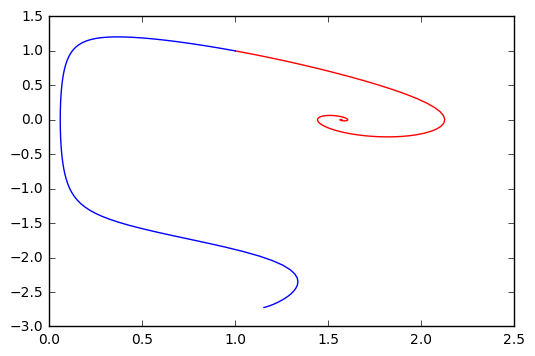

In [22]:
A=stiff_int(F,10,[1,1],[-5,5],[-5,5])

B=stiff_int(F,-5,[1,1],[-5,5],[-5,5])

A.shape

plot(A[:,0],A[:,1],'r-')
plot(B[:,0],B[:,1],'b-')

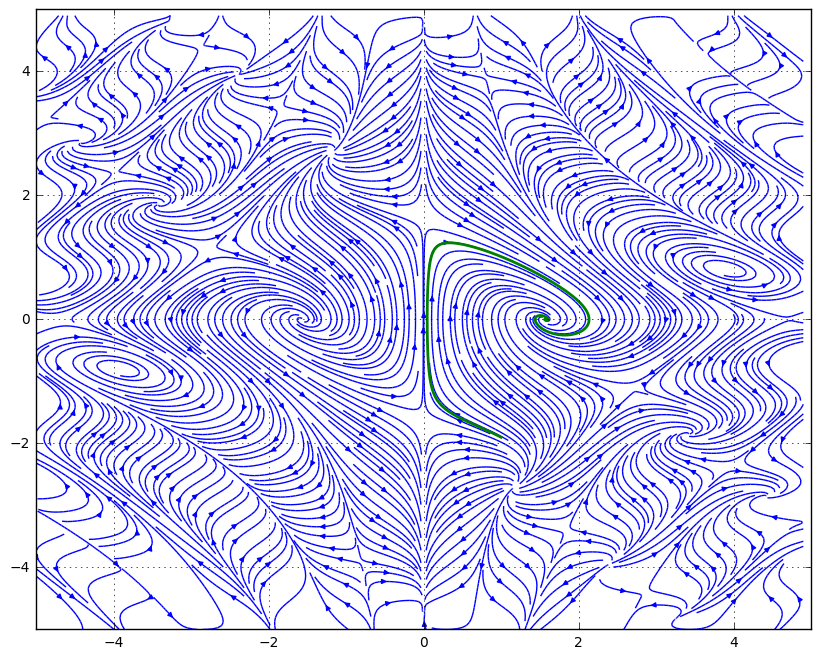

In [23]:
fig = figure(figsize=[10,8])
streamplot(X[:,0],Y[0,:],*F([X,Y]),density=5)
plot(sol15s[:,0],sol15s[:,1],'g-',lw=2)
xlim(plot_range)
ylim(plot_range)
grid(True)

In [32]:
# Line Integral Convolution

# x,y: length 2 vectors of x and y ranges over which to sample F
# F: callable function representing vector field
# tex: 2d array representing input texture (same size as F)
# L: scalar - max path length for line integral
# kernel: callable function to use as convolution kernel
def LIC(F,xrange,yrange,tex,L=10,kernel=None):
    # If no kernel is given, use boxcar
    if kernel == None:
        def kernel(x):
            return 0*x + (abs(x)<1).astype(float)
    
    # tex is an nxm array
    # x has length n
    # y las length m
    n,m = tex.shape
    
    # from unit-spaced i,j texture coords to vector field x,y coords
    # i,j measured from top left
    # x,y measured from bottom right
    # i,j need not necessarily be integers
    # P_ij.shape = (2,)
    def ij_to_xy(P_ij):
        i,j = P_ij
        x = xrange[0] + j/m * (xrange[1] - xrange[0])
        y = yrange[1] - i/n * (yrange[1] - yrange[0])
        return array([x,y])
    
    # Convert from xy to ij
    # i,j measured from top left
    # x,y measured from bottom right
    # P_xy.shape = (N,2)
    def xy_to_ij(P_xy):
        x,y = P_xy.T
        i = (1 - (y - yrange[0]) / (yrange[1] - yrange[0])) * n
        j = (x - xrange[0]) / (xrange[1] - xrange[0]) * m
        return array([i,j]).T
    
    # Output texture
    out_tex = zeros_like(tex)
    
    # Loop through pixels
    for i in range(n):
        print("i={}/{}".format(i,n-1))
        for j in range(m):
            #print("j={}/{}".format(j,m))
            # Advection points - to be appended each step
            # Initial point is center of pixel
            # In ij coordinates
            P_ij = array([i+0.5,j+0.5])
            
            # Convert P to xy coords
            P_xy = ij_to_xy(P_ij)
            
            # Solve ODE
            forward_path_xy = stiff_int(F,L,P_xy,xrange,yrange)
            reverse_path_xy = stiff_int(F,-L,P_xy,xrange,yrange)
            
            #print("IC(ij): {}".format(ij_to_xy(P)))
            #print("forward path:")
            #print(forward_path_xy)
            
            # Convert solution to ij coords
            forward_path = xy_to_ij(forward_path_xy)
            reverse_path = xy_to_ij(reverse_path_xy)
            
            #if i == 20 and j == 20:
            #    grayim(tex)
            #    print("P_ij = {}".format(P_ij))
            #    print("P_xy = {}".format(P_xy))
            #    print("FP:")
            #    print(forward_path)
            #    print("RP:")
            #    print(reverse_path)
            #    plot(forward_path[:,0],forward_path[:,1],'b-')
            #    plot(reverse_path[:,0],reverse_path[:,1],'r-')
            #    draw()
            #    show()
            #    break
            
            # Individual step lengths
            forward_step_lengths = path_length(forward_path)
            reverse_step_lengths = path_length(reverse_path)
            # Cumulative path lengths
            forward_path_lengths = forward_step_lengths.cumsum()
            reverse_path_lengths = reverse_step_lengths.cumsum()
            
            # Integrate input texture times kernel along path
            # Use left endpoint rule
            forward_cells = grid_cell(forward_path)
            forward_tex_int = (tex[forward_cells[:-1,0],forward_cells[:-1,1]] \
                               * kernel(forward_path_lengths) \
                               / forward_step_lengths).sum()
            
            # Plot one example
            if i == 20 and j == 20:
                fig = figure(figsize=[10,8])
                grayim(noise,ext=[xrange[0],xrange[1],yrange[0],yrange[1]])
                plot(forward_path_xy[:,0],forward_path[:,1],'-b')
                plot(reverse_path_xy[:,0],reverse_path[:,1],'-r')
                draw()
                show()
            
            reverse_cells = grid_cell(reverse_path)
            reverse_tex_int = (tex[reverse_cells[:-1,0],reverse_cells[:-1,1]] \
                               * kernel(reverse_path_lengths) \
                               / reverse_step_lengths).sum()
            
            # Integrate kernel along path length
            # Use left endpoint rule
            forward_ker_int = (kernel(forward_path_lengths)/forward_step_lengths).sum()
            reverse_ker_int = (kernel(reverse_path_lengths)/reverse_step_lengths).sum()
            
            # Sum & divide to produce output texture
            out_tex[i,j] = (forward_tex_int + reverse_tex_int) / (forward_ker_int + reverse_ker_int)
    
    # Return output texture
    return out_tex
    

i=0/99


/home/oliver/local/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py:112: RuntimeWarning: invalid value encountered in double_scalars


i=1/99
i=2/99
i=3/99
i=4/99
i=5/99
i=6/99
i=7/99
i=8/99
i=9/99
i=10/99
i=11/99
i=12/99
i=13/99
i=14/99
i=15/99
i=16/99
i=17/99
i=18/99
i=19/99
i=20/99


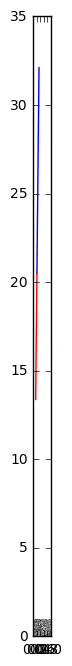

i=21/99
i=22/99
i=23/99
i=24/99
i=25/99
i=26/99
i=27/99
i=28/99
i=29/99
i=30/99
i=31/99
i=32/99
i=33/99
i=34/99
i=35/99
i=36/99
i=37/99
i=38/99
i=39/99
i=40/99
i=41/99
i=42/99
i=43/99
i=44/99
i=45/99
i=46/99
i=47/99
i=48/99
i=49/99
i=50/99
i=51/99
i=52/99
i=53/99
i=54/99
i=55/99
i=56/99
i=57/99
i=58/99
i=59/99
i=60/99
i=61/99
i=62/99
i=63/99
i=64/99
i=65/99
i=66/99
i=67/99
i=68/99
i=69/99
i=70/99
i=71/99
i=72/99
i=73/99
i=74/99
i=75/99
i=76/99
i=77/99
i=78/99
i=79/99
i=80/99
i=81/99
i=82/99
i=83/99
i=84/99
i=85/99
i=86/99
i=87/99
i=88/99
i=89/99
i=90/99
i=91/99
i=92/99
i=93/99
i=94/99
i=95/99
i=96/99
i=97/99
i=98/99
i=99/99


In [33]:
A = LIC(F,[0,1],[0,1],noise[:,:,0])

In [26]:
A.shape

(100, 100)

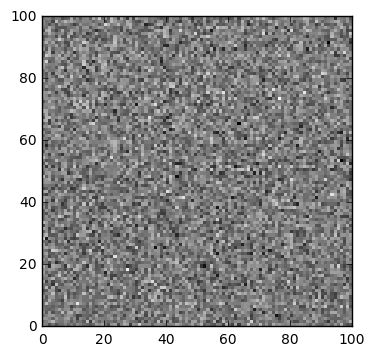

In [27]:
grayim(noise)

/home/oliver/local/miniconda3/lib/python3.5/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


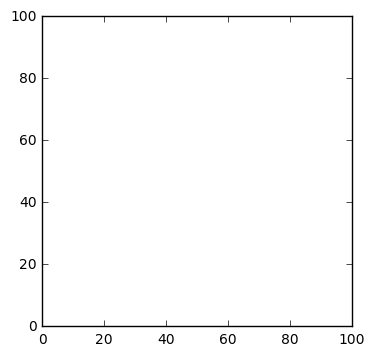

In [28]:
grayim(A)

In [29]:
x=linspace(2,7,13)
y=linspace(1,9,13)
X = array([x,y]).T

grid_cell(X)

array([[1, 2],
       [1, 2],
       [2, 2],
       [3, 3],
       [3, 3],
       [4, 4],
       [5, 4],
       [5, 4],
       [6, 5],
       [7, 5],
       [7, 6],
       [8, 6],
       [9, 7]])

In [30]:
A = arange(30).reshape(6,5)

In [31]:
A[X]

IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
A==X

In [ ]:
X[range(5),1]

In [ ]:
x = array([[0,1]])

In [ ]:
x = arange(10)